## The Advanced Computing Center for Research and Education

The Advanced Computing Center for Research and Education (ACCRE) is a computer cluster serving the high-performance computing needs of research for Vanderbilt University. In this data question, you will be analyzing data on jobs run on ACCRE's hardware.

The computing resources in the ACCRE cluster are divided into nodes. Each node is equipped with some number of CPUs, and some of the nodes contain GPUs (graphical processing units).  You have been provided a dataset, **accre-gpu-jobs-2022.csv**, which contains information on jobs submitted to ACCRE's GPU partitions. Traditionally GPUs were designed to power video games to perform calculations quickly. Because of the nature of their design, GPUs are being used more and more for non-graphics applications as well (e.g. for deep learning applications, molecular dynamics, image processing, and much more).

Recently, more researchers are performing work that requires GPU acceleration. Your task in this project is to analyze the GPU jobs that have been run on ACCRE over the last few years in order to better understand what needs to be provisioned moving forward. 

ACCRE has three scheduler partitions that groups can get access to which consist of machines each with 4 GPU cards. Each partition is named after the nvidia processor generation that it contains, from oldest to newest: maxwell, pascal, and turing. GPU nodes are requested per-GPU, and users can request up to 4 GPUs per node. For each GPU the user is allocated up to one quarter of the machine's RAM and CPU cores. All of the current GPU-accelerated hardware is also connected to a special high-speed RoCE (RDMA over converged ethernet) network allowing for memory sharing on large-scale multi-GPU jobs, so users can also request multiple servers for analysis that requires more than four GPU cards.

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
accre_df = pd.read_csv('../data/accre-gpu-jobs-2022-v2.csv', on_bad_lines='warn')

b'Skipping line 124084: expected 12 fields, saw 13\nSkipping line 124809: expected 12 fields, saw 13\n'


there are 2 bad lines, we'll ignore them for now...

In [3]:
accre_df.shape

(336950, 12)

Found this out later, the REQTIME, USEDTIME and USEDMEM are objects, have to remove junk and convert them:

In [4]:
accre_df['USEDMEM'] = accre_df['USEDMEM'].str.replace(r'M','', regex=True).astype(float)

accre_df['REQTIME'] = pd.to_timedelta(accre_df['REQTIME'].str.replace(r'-',' days ', regex=True))
accre_df['USEDTIME'] = pd.to_timedelta(accre_df['USEDTIME'].str.replace(r'-',' days ', regex=True))

We (pizza group) also decided to split up the dataframe. Dropping all of the running and pending jobs first (being 1258)

In [5]:
accre_df = accre_df[~accre_df['STATE'].isin(['RUNNING','PENDING'])]

up next, we decided to save the cancelled jobs in a separate dataframe. After that, just to make sure it contains only cancelled in various forms:

`pd.unique(accre_cancelled['STATE'])`

In [6]:
accre_cancelled = accre_df[~accre_df['STATE'].isin(['COMPLETED','FAILED','OUT_OF_MEMORY'])]

And finally, the dataframe that we will be using for most of our analysis (only status codes COMPLETED, FAILED or OUT OF MEMORY)

In [7]:
accre_df = accre_df[accre_df['STATE'].isin(['COMPLETED','FAILED','OUT_OF_MEMORY'])]

In [8]:
accre_df.shape

(283776, 12)

By doing all that, we got rid of 53174 rows!

### Onto some exploration regarding to the very first point

The main objectives of this project are to examine the following questions:
1. What is the distribution of per-GPU main memory usage over all runtime-weighed jobs in each partition? Knowing this will help ACCRE to understand our users memory needs for future hardware purchases.

We've actually done some of this analysis before; but after reformatting the notebook it's now here. How many jobs have used 0 memory (because they ran less than 2 min or otherwise):

`accre_df.groupby('USEDMEM').count()`

`accre_df[(accre_df['USEDMEM'] == '0') | (accre_df['USEDMEM'] == '0.00M')]`

Turns out that was 336950 jobs (0 or 0.00M)

In [9]:
accre_noM = accre_df[(accre_df['USEDMEM'] != '0') & (accre_df['USEDMEM'] != '0.00M')]

In [10]:
accre_noM.shape

(283776, 12)

After the cleanup from earlier, we only got rid of 5919 jobs here. That is important because some of them had runtimes which would affect the analysis. Initially did some additional exploration into various errors and codes; omitted here.

In [11]:
accre_noM[accre_noM['STATE'] == 'OUT_OF_MEMORY']

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
332639,46247498,glasshouse,tommie,138663.87,5 days 00:00:00,0 days 18:01:08,2,24,8,turing,0:125,OUT_OF_MEMORY
333434,46329470,pasilla,venus,7.19,0 days 00:30:00,0 days 00:05:05,1,1,1,turing,0:125,OUT_OF_MEMORY
334513,46514679,glasshouse,arnoldo,24221.36,0 days 04:00:00,0 days 01:11:23,1,6,1,turing,0:125,OUT_OF_MEMORY


kind of interesting that a job failed with only 7.19M usage and 5 minutes of run time.

In [12]:
accre_noM.groupby('NODES').count()

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,CPUS,GPUS,PARTITION,EXITCODE,STATE
NODES,,,,,,,,,,,
0,63,63,63,63,63,63,63,63,63,63,63
1,282887,282887,282887,282887,282887,282887,282887,282887,282887,282887,282887
2,330,330,330,330,330,330,330,330,330,330,330
3,363,363,363,363,363,363,363,363,363,363,363
4,48,48,48,48,48,48,48,48,48,48,48
5,57,57,57,57,57,57,57,57,57,57,57
6,8,8,8,8,8,8,8,8,8,8,8
7,12,12,12,12,12,12,12,12,12,12,12
9,1,1,1,1,1,1,1,1,1,1,1


In [13]:
accre_noM[accre_noM['NODES'] == 15]

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
62122,37020263,pasilla,dola,2.53,0 days 00:20:00,0 days 00:00:03,15,120,60,pascal,0:0,COMPLETED
270301,44976228,pasilla,dola,7.41,0 days 00:20:00,0 days 00:00:02,15,120,60,pascal,0:0,COMPLETED


Another interesting observation here that there were 2 jobs, from the same account and user who required 15 nodes (60) gpus; much more than anyone else!

Back to the question ... My understanding of the question 1) memory/gpu * time(job)/time(total)

In [14]:
accre_noM.groupby('PARTITION')['USEDTIME'].sum()

PARTITION
maxwell   2642 days 03:08:29
pascal    9780 days 21:19:05
turing    6407 days 15:58:37
Name: USEDTIME, dtype: timedelta64[ns]

In [15]:
accre_noM['TOT_USEDTIME_PART'] = accre_noM.groupby('PARTITION')['USEDTIME'].transform('sum').to_frame()

In [16]:
accre_noM['WEIGHTED_MEM_GPU'] = (
    (accre_noM['USEDMEM']/ accre_noM['GPUS']) *
    (accre_noM['USEDTIME']/accre_noM['TOT_USEDTIME_PART'])
)

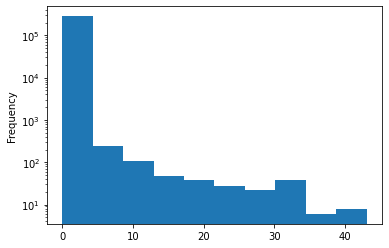

In [17]:
plt.axis
accre_noM['WEIGHTED_MEM_GPU'].plot(kind='hist', log='True');

Very heavy skew visible above -> meaning that most jobs take only a fraction of total time (per partition) and/or use very little memory. Let's compare partitions.

In [24]:
accre_noM.groupby('PARTITION')['WEIGHTED_MEM_GPU'].sum()

PARTITION
maxwell    2297.826032
pascal     2751.601922
turing     9277.105272
Name: WEIGHTED_MEM_GPU, dtype: float64

Even though more time (overall) was spent on Pascal than Turing, the memory usage of the latter one prevails. It's also interesting how close together Maxwell and Pascal are. Also, using the describe below, we can see how heavily the data is skewed.

In [23]:
accre_noM.groupby('PARTITION')['WEIGHTED_MEM_GPU'].describe()

,count,mean,std,min,25%,50%,75%,max
PARTITION,,,,,,,,
maxwell,127160.0,0.018070,0.477414,0.0,2.426843e-07,0.000904,0.001294,42.982171
pascal,81544.0,0.033744,0.379766,0.0,5.820515e-05,0.000834,0.002996,26.793911
turing,75072.0,0.123576,1.181682,0.0,1.873841e-07,0.000754,0.002275,43.074130


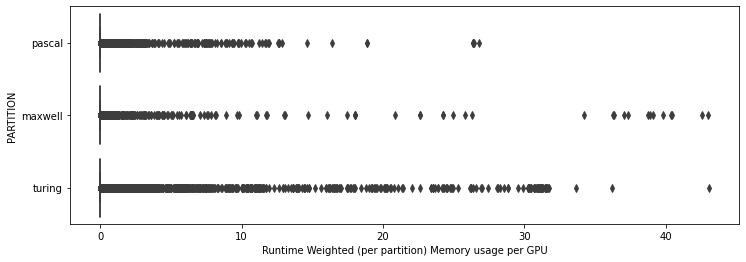

In [27]:
fig, ax = plt.subplots(figsize = (12,4))

sns.boxplot(
            data=accre_noM, 
            x='WEIGHTED_MEM_GPU', 
            y='PARTITION', 
            ax=ax
)
plt.xlabel('Runtime Weighted (per partition) Memory usage per GPU');

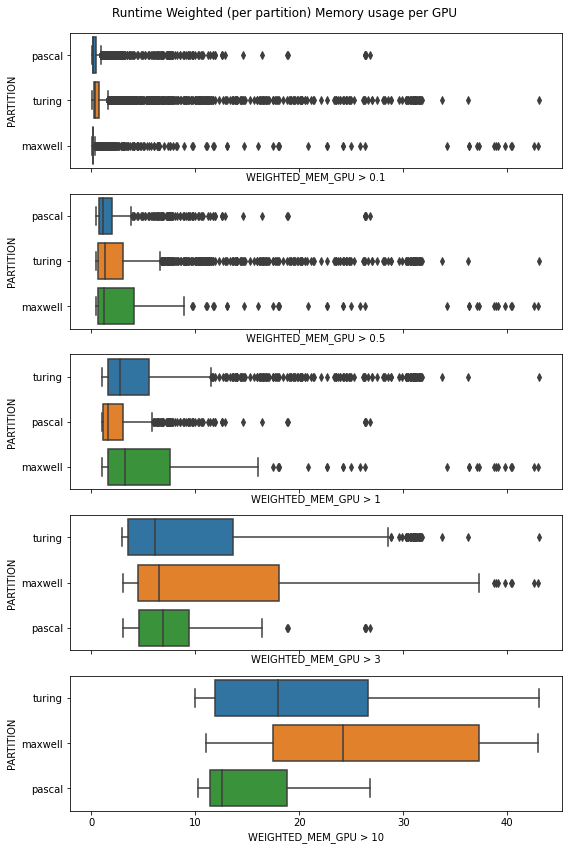

In [50]:
#Trying to plot the above by making cuts at different values
fig, axes = plt.subplots(5, sharex=True, figsize=(8, 12))
axes = axes.flatten()
fig.suptitle('Runtime Weighted (per partition) Memory usage per GPU')

ax = sns.boxplot(
        data=accre_noM.loc[accre_noM['WEIGHTED_MEM_GPU']>0.1], 
        x='WEIGHTED_MEM_GPU', 
        y='PARTITION',
        orient='h',
        ax=axes[0]
)
axes[0].set_xlabel('WEIGHTED_MEM_GPU > 0.1')

ax = sns.boxplot(
        data=accre_noM.loc[accre_noM['WEIGHTED_MEM_GPU']>0.5], 
        x='WEIGHTED_MEM_GPU', 
        y='PARTITION',
        orient='h',
        ax=axes[1]
)
axes[1].set_xlabel('WEIGHTED_MEM_GPU > 0.5')

ax = sns.boxplot(
        data=accre_noM.loc[accre_noM['WEIGHTED_MEM_GPU']>1], 
        x='WEIGHTED_MEM_GPU', 
        y='PARTITION',
        orient='h',
        ax=axes[2]
)
axes[2].set_xlabel('WEIGHTED_MEM_GPU > 1')

ax = sns.boxplot(
        data=accre_noM.loc[accre_noM['WEIGHTED_MEM_GPU']>3], 
        x='WEIGHTED_MEM_GPU', 
        y='PARTITION',
        orient='h',
        ax=axes[3]
)
axes[3].set_xlabel('WEIGHTED_MEM_GPU > 3')

ax = sns.boxplot(
        data=accre_noM.loc[accre_noM['WEIGHTED_MEM_GPU']>10], 
        x='WEIGHTED_MEM_GPU', 
        y='PARTITION',
        orient='h',
        ax=axes[4]
)
axes[4].set_xlabel('WEIGHTED_MEM_GPU > 10')

fig = ax.get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.95)


2. What is the distribution of the number of GPUs in each job (runtime-weighted) for each partition? What fraction of runtime-weighted and GPU-weighted jobs are using more than 4 GPUs and thus probably using the RoCE networking? Is this fraction different for each partition?
3. What is the total runtime usage per-gpu (i.e. multiply runtime by the number of gpus) in each of the 3 partitions over the last year?
4. What is the distribution of different groups and users accessing each partition? In each partition, who are the top users, and do they represent a majority of the runtime-weighted jobs on the partition?
5. Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum?